# 2. Tensorflow Prophet Testing

## I - Setup

In [1]:
# Import of librairies
import mysql.connector as mariadb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from tqdm import tqdm
from datetime import timedelta
import time 

class sql_query:
    def __init__(self, credentials_path):
        self.db_credentials = pd.read_csv(credentials_path, index_col="Field")
      
    
    def __call__(self, query):
        
        mariadb_connection = mariadb.connect(
            user=self.db_credentials.loc["user"][0],
            password=self.db_credentials.loc["password"][0],
            host=self.db_credentials.loc["host"][0],
            port=3306,
            db = "db_velib")
        
        self.cursor = mariadb_connection.cursor()
        cursor = self.cursor
        cursor.execute("SET  time_zone = 'Europe/Paris'")
        cursor.execute(query)
        field_names = [i[0] for i in cursor.description]
        df = pd.DataFrame(cursor, columns=field_names)
        return df
    
# Modify later query to have last value and df

def retrieve_results():

    request = sql_query("../../aws_mariadb_crendentials.csv")
    query = """
    SELECT * FROM velib_results
    """
    df = request(query)

    # Limiting data temporarily
    df = df[:20]

    # Modifications

    df.last_observations = df.last_observations.apply(lambda x: list(map(float, x[1:-1].split())))
    df.model_A = df.model_A.apply(lambda x: list(map(float, x[1:-1].split())))
    df.model_B = df.model_B.apply(lambda x: list(map(float, x[1:-1].split())))

    return df

def dataframe_restition(station_id, df):
    
    try:
    
        graph_data = df[df['station_id'] == station_id]

        df_restitution = pd.DataFrame(columns=['last_observations','model_A','model_B'],
                     index=range(43))

        df_restitution['last_observations'][0:37] = graph_data.last_observations[graph_data.index[0]]
        df_restitution['model_A'][0:37] = graph_data.last_observations[graph_data.index[0]]
        df_restitution['model_B'][0:37] = graph_data.last_observations[graph_data.index[0]]
        df_restitution['model_A'][37:43] = graph_data.model_A[graph_data.index[0]]
        df_restitution['model_B'][37:43] = graph_data.model_B[graph_data.index[0]]
        df_restitution.index=pd.date_range((df.date_of_prediction[graph_data.index[0]] - timedelta(minutes=36)), periods=43, freq='Min')

        df_restitution = df_restitution.fillna(0)

        df_restitution['last_observations'] = df_restitution['last_observations'].apply(lambda x: int(x))
        df_restitution['model_A'] = df_restitution['model_A'].apply(lambda x: int(round(x)))
        df_restitution['model_B'] = df_restitution['model_B'].apply(lambda x: int(round(x)))

        return df_restitution
    except:
        print('Data currently not availiable')
def graphical_restition(df_restitution):
    try:
        f, ax = plt.subplots(figsize=(10,5))

        ax.set_ylim(0, max(df_restitution[max(df_restitution)])+5)
        #x1, y1 = [30, 31], [20, 20]
        #ax = plt.plot(x1, y1, linestyle="dashdot", color="red")

        histo_start_index = 30
        histo_end_index = 36
        _ = sns.lineplot(x=df_restitution.index[histo_start_index:], y=df_restitution['model_A'][histo_start_index:].values, color='cyan', label='Forecast A')
        _ = sns.lineplot(x=df_restitution.index[histo_start_index:], y=df_restitution['model_B'][histo_start_index:].values, color='blue', label='Forecast B')
        _ = sns.lineplot(x=df_restitution.index[histo_start_index:histo_end_index+1], y=df_restitution.iloc[histo_start_index:histo_end_index+1]['last_observations'].values, color='green', label="Historical Values")

        plt.axvline(x=df_restitution.index[histo_end_index],color='green', linestyle="dashdot")

        plt.title('Velib availiability at {}'.format(str(df_restitution.index[36])))

        plt.show()
        
    except:
        print('Data currently not availiable')

## I - Initialization

In [2]:
# Retrieving last results
df = retrieve_results()

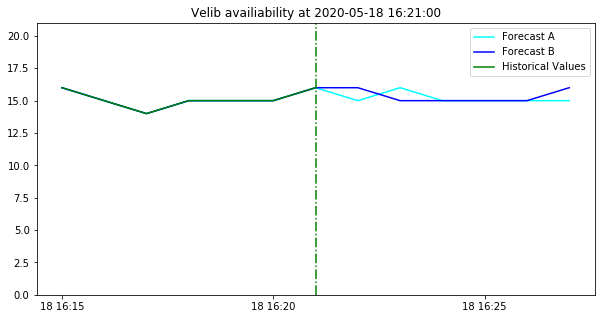

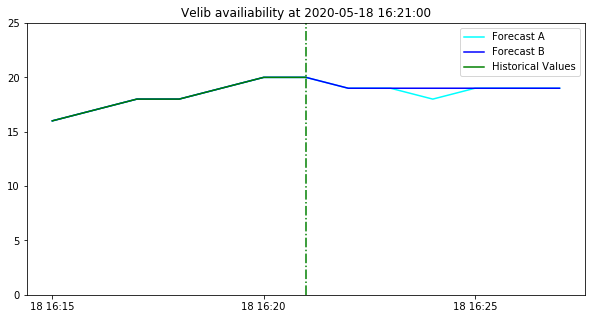

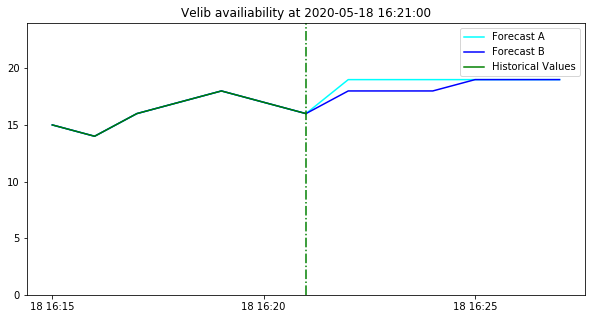

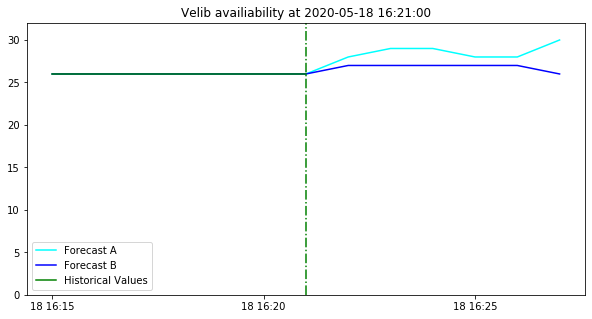

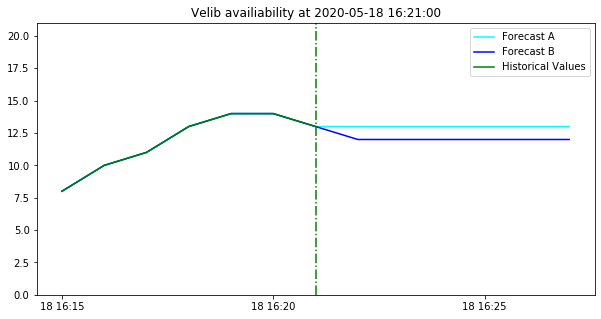

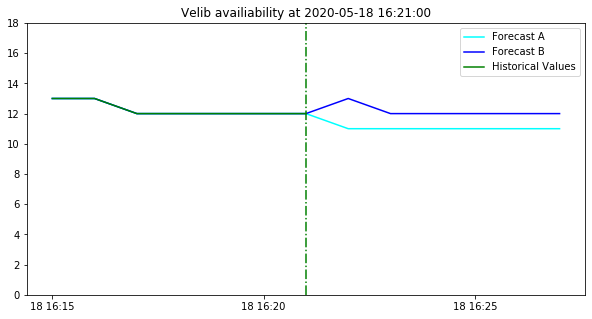

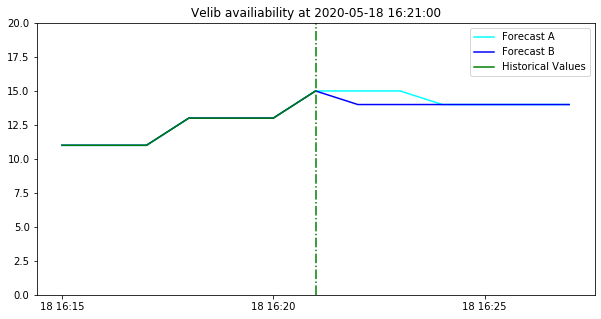

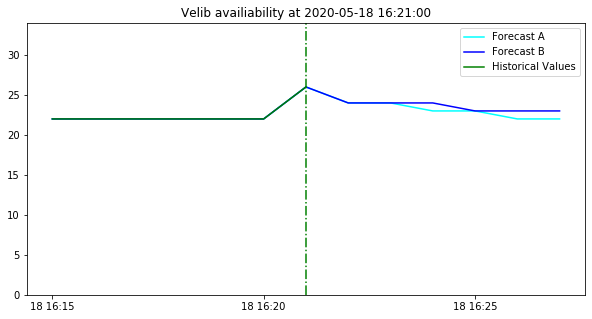

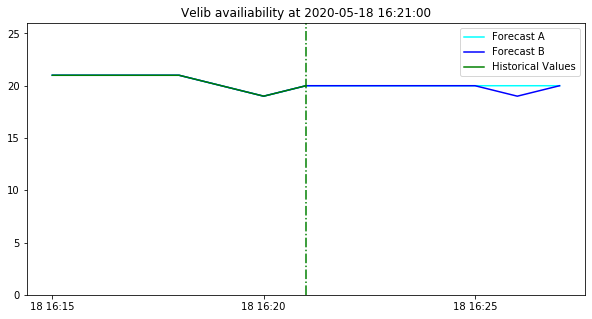

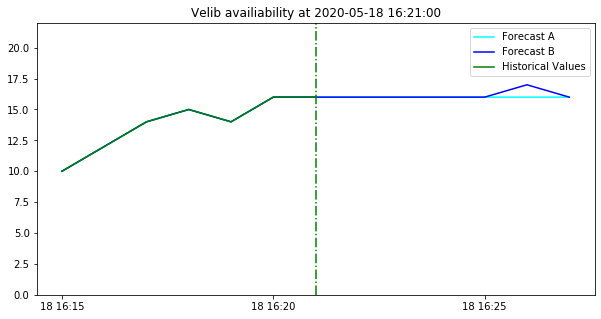

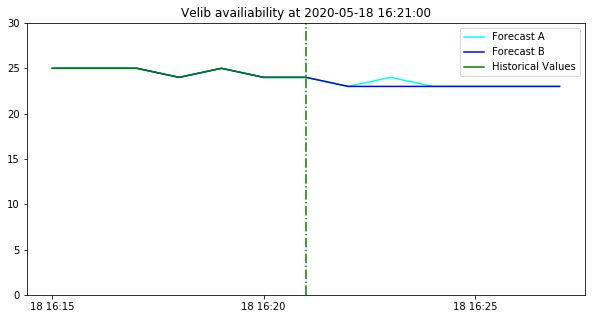

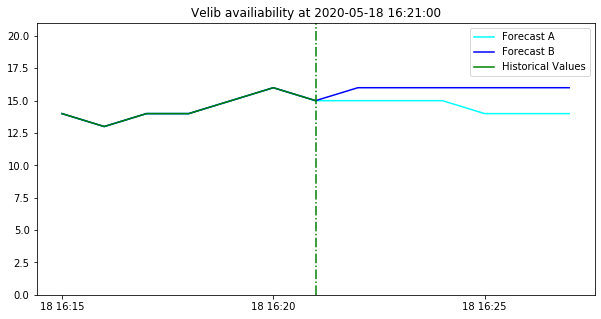

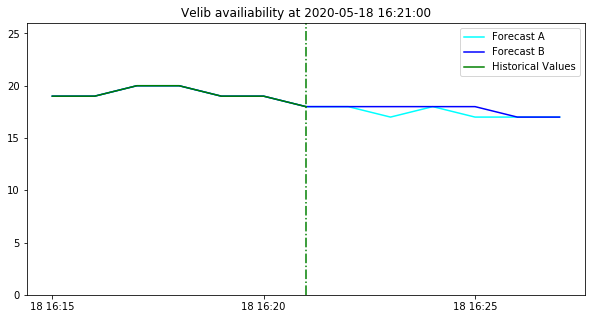

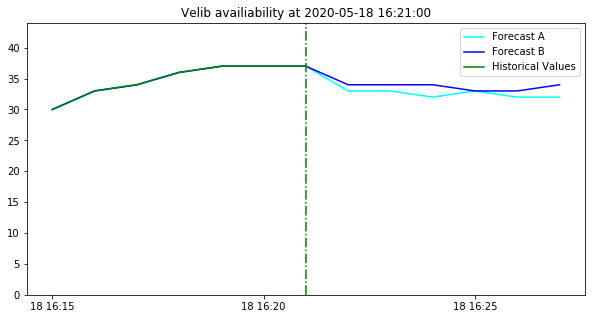

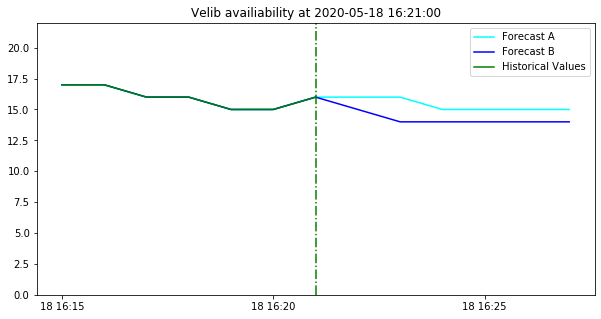

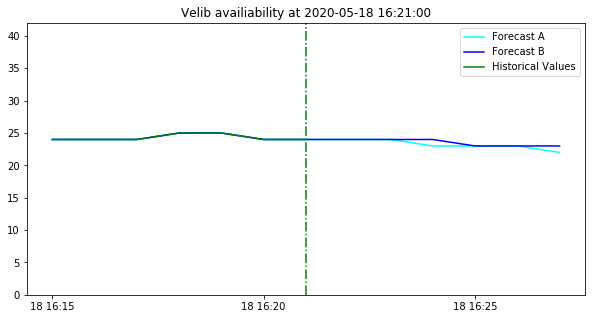

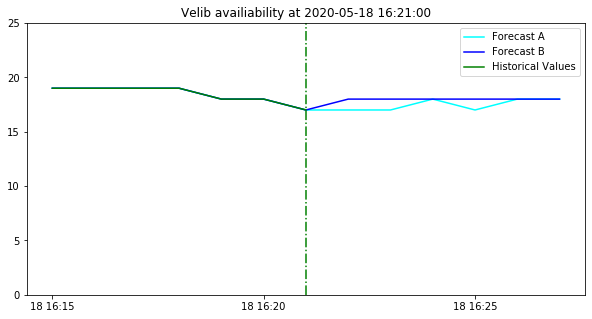

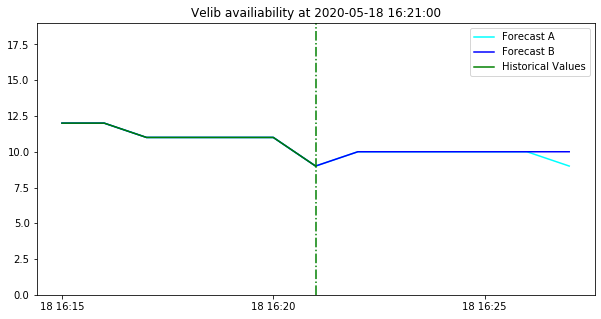

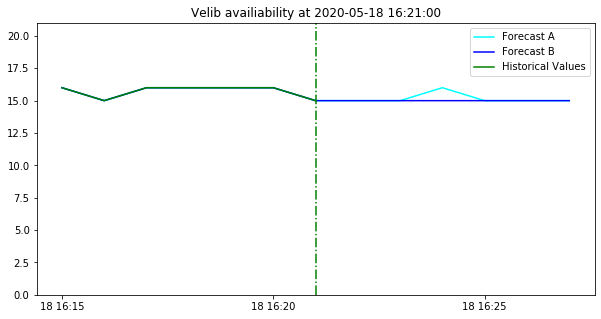

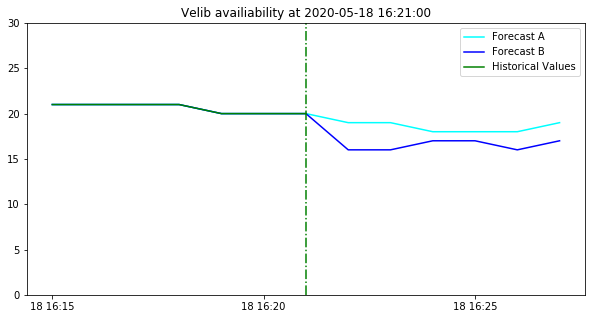

In [3]:
# retrieving date_of update

for station_id in df.station_id[:20]:
    graphical_restition(dataframe_restition(station_id, df))